In [ ]:
# Connecting Google Drive with Google Colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path='drive/My Drive/xray dataset'

In [ ]:
# Basic Imports
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

# Imports for Building CNN
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

categories = ["NORMAL", "PNEUMONIA"]

# File Path to all Required Folders
train_path = (path+'/chest_xray/train')
test_path = (path+'/chest_xray/test')
val_path = (path+'/chest_xray/val')

## Viewing Some Random Images

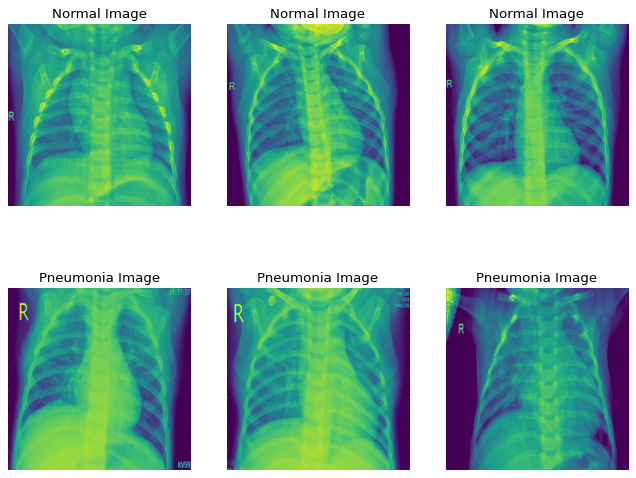

In [ ]:
train_normal_images = glob(train_path+"/NORMAL/*")
train_pneumonia_images = glob(train_path+"/PNEUMONIA/*")

plt.figure(figsize=(10, 8), dpi=80)
init_subplot = 230
for i in range(1, 7):
    plt.subplot(init_subplot + i)
    
    if i < 4:
        img = Image.open(np.random.choice(train_normal_images)).resize((244, 244))
        plt.title("Normal Image")
    else:
        img = Image.open(np.random.choice(train_pneumonia_images)).resize((244, 244))
        plt.title("Pneumonia Image")
        
    img = np.asarray(img)
    plt.axis('off')
    plt.imshow(img)

## VGG16 Kersas Model for Image Classification

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape = IMAGE_SIZE + [3],
            weights = 'imagenet',
            include_top=False)

#not training the existing weights
for layer in vgg.layers:
  layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


## Adding Some More Layers in Our VGG16 Model

In [ ]:
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)


prediction = Dense(len(categories), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Compiling the Model

In [ ]:

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# Preparing Images for Model

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

## Getting the Images in Batches and Scaling them

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Training our VGG16 - CNN Model

In [ ]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=1,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

163/163 [==============================] - 3138s 19s/step - loss: 0.8277 - accuracy: 0.9061 - val_loss: 0.4044 - val_accuracy: 0.9006


Saving the Trained model

In [ ]:
model.save('vgg16_model.h5')